In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pickle
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

In [152]:
TRAIN_IMAGES_SOURCE_PICKLE = '/content/drive/My Drive/ml/full_CNN_train.p'
LABELS_SOURCE_PICKLE = '/content/drive/My Drive/ml/full_CNN_labels.p'


train_images = pickle.load(open(TRAIN_IMAGES_SOURCE_PICKLE, "rb" ))
train_images = np.array(train_images)

labels = pickle.load(open(LABELS_SOURCE_PICKLE, "rb" ))
labels = np.array(labels)


print(train_images.shape)
print(labels.shape)

(12764, 80, 160, 3)
(12764, 80, 160, 1)


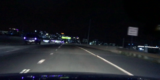

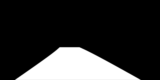

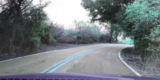

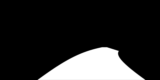

In [252]:
cv2_imshow(train_images[0])
cv2_imshow(labels[0])
print('===================')
cv2_imshow(train_images[1105])
cv2_imshow(labels[1105])

In [0]:
DATASET_FROM = 1000
DATASET_TO = 2000

# split images into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    train_images[DATASET_FROM:DATASET_TO], 
    labels[DATASET_FROM:DATASET_TO], 
    test_size=0.1)

In [0]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

In [0]:
model = Sequential()

pool_size = (2, 2)

model.add(BatchNormalization(input_shape=x_train.shape[1:]))

model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))


model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(Dropout(0.2))


model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(UpSampling2D(size=pool_size))


model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))


model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(Dropout(0.2))

model.add(UpSampling2D(size=pool_size))

model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(Dropout(0.2))

model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(Dropout(0.2))

model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(Dropout(0.2))

model.add(UpSampling2D(size=pool_size))


model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

In [235]:
model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit(x=x_train,
         y=y_train,
         epochs=5,
         validation_data=(x_test, y_test))

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 73s 82ms/step - loss: 7790.5002 - val_loss: 6446.9475
Epoch 2/5
900/900 [==============================] - 63s 70ms/step - loss: 4170.3640 - val_loss: 4730.4458
Epoch 3/5
900/900 [==============================] - 64s 71ms/step - loss: 3159.2408 - val_loss: 3325.9375
Epoch 4/5
900/900 [==============================] - 64s 71ms/step - loss: 2404.8954 - val_loss: 3609.9994
Epoch 5/5
900/900 [==============================] - 64s 71ms/step - loss: 1464.1126 - val_loss: 2725.3052


In [0]:
MODEL_PATH = '/content/model.h5'
model.save(MODEL_PATH)

# reload model from disk
model = load_model(MODEL_PATH)

original image shape: (80, 160, 3)


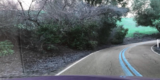

predicted shape: (80, 160, 1)


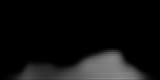

binarized shape: (80, 160)


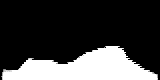

predicted shape with fake layers: (80, 160, 3)


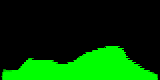

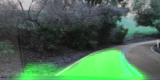

In [249]:
original_img = train_images[8001]
print('original image shape:', original_img.shape)
cv2_imshow(original_img)


test_img = original_img[None, :,:,:]
predicted_img = model.predict(test_img)[0]
print('predicted shape:', predicted_img.shape)
cv2_imshow(predicted_img)


# переводим в grayscale
predicted_img = predicted_img * 255


# биаризуем изображение
predicted_img = cv2.threshold(predicted_img, 127, 255, cv2.THRESH_TOZERO)[1]
print('binarized shape:', predicted_img.shape)
cv2_imshow(predicted_img)

# изображение с предсказанной разметкой - черно-белое
# надо добавить 2 фейковых слоя, чтобы превратить его в RGB
fake_layer = np.zeros_like(predicted_img).astype(np.uint8)
# BGR: Red = fake, Green = predicted, Blue = fake
predicted_rgb = np.dstack((fake_layer, predicted_img, fake_layer))
# приводим все слои к одному типу
# predicted_rgb = predicted_rgb.astype(np.uint8)
print('predicted shape with fake layers:', predicted_rgb.shape)
cv2_imshow(predicted_rgb)



merged_img = cv2.addWeighted(src1=original_img.astype(np.float32), 
                             alpha=0.8, 
                             src2=predicted_rgb, 
                             beta=0.01, 
                             gamma=0)
cv2_imshow(merged_img)

In [0]:
def predict_road_lane(original: np.array) -> np.array:
    original_4d = original[None, :,:,:]

    predicted = model.predict(original_4d)[0]
    predicted = predicted * 255

    predicted = cv2.threshold(predicted, 127, 255, cv2.THRESH_TOZERO)[1]

    fake_layer = np.zeros_like(predicted).astype(np.uint8)
    predicted_rgb = np.dstack((fake_layer, predicted, fake_layer))
    

    merged_img = cv2.addWeighted(src1=original.astype(np.float32), 
                                 alpha=0.8, 
                                 src2=predicted_rgb, 
                                 beta=0.01, 
                                 gamma=0)
    return merged_img

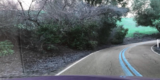

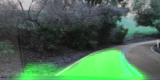

In [239]:
orig = train_images[8001]
cv2_imshow(orig)
pred = predict_road_lane(orig)
cv2_imshow(pred)

In [0]:
import os

VIDEO_FRAMES_DIR = '/content/frames'
os.makedirs(VIDEO_FRAMES_DIR, exist_ok=True)

for i in range(800, 1000):
    predicted_frame = predict_road_lane(train_images[i])
    cv2.imwrite(f'{VIDEO_FRAMES_DIR}/{i}.png', predicted_frame)

In [251]:
from moviepy.editor import *


def create_movie(movie_name: str, frames_dir: str) -> None:
    frame_imgs = sorted(os.listdir(frames_dir))
    frames = list(map(lambda frm: ImageClip(f'{frames_dir}/{frm}').set_duration(0.1), frame_imgs))

    clip = concatenate_videoclips(frames, method='compose')
    clip.write_videofile(movie_name, fps=24)


create_movie('/content/roadmovie.mp4', VIDEO_FRAMES_DIR)

[MoviePy] >>>> Building video /content/roadmovie.mp4
[MoviePy] Writing video /content/roadmovie.mp4





  0%|          | 0/481 [00:00<?, ?it/s]


 12%|█▏        | 59/481 [00:00<00:00, 581.32it/s]


 21%|██        | 99/481 [00:00<00:00, 510.62it/s]


 30%|██▉       | 143/481 [00:00<00:00, 485.08it/s]


 39%|███▉      | 187/481 [00:00<00:00, 468.19it/s]


 48%|████▊     | 232/481 [00:00<00:00, 461.80it/s]


 58%|█████▊    | 277/481 [00:00<00:00, 457.37it/s]


 67%|██████▋   | 321/481 [00:00<00:00, 449.88it/s]


 76%|███████▌  | 364/481 [00:00<00:00, 442.50it/s]


 84%|████████▍ | 406/481 [00:00<00:00, 422.19it/s]


 94%|█████████▎| 450/481 [00:01<00:00, 425.49it/s]


100%|██████████| 481/481 [00:01<00:00, 438.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/roadmovie.mp4 

